# Sentiment Analysis

先確認已安裝以下套件：
pandas, jieba, numpy, matplotlib, gensim, sklearn

## Load data 

In [48]:
import pandas as pd
df = pd.read_csv('data/sentiment.csv')
df.head(5)

,tag,text
0,P,店家很給力，快遞也是相當快，第三次光顧啦
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。
2,P,不錯，在同等檔次酒店中應該是值得推薦的！
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字


In [49]:
print(len(df))
print(df['tag'].value_counts())

6388
N    3347
P    3041
Name: tag, dtype: int64


## Tokenization

In [50]:
import jieba
df['token_text'] = df['text'].apply(lambda x:list(jieba.cut(x)))
df.head(5)

,tag,text,token_text
0,P,店家很給力，快遞也是相當快，第三次光顧啦,"[店家, 很, 給力, ，, 快遞, 也, 是, 相當快, ，, 第三次, 光顧, 啦]"
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。,"[這樣, 的, 配置, 用, Vista, 系統, 還是, 有點, 卡, 。, , 指紋,..."
2,P,不錯，在同等檔次酒店中應該是值得推薦的！,"[不錯, ，, 在, 同等, 檔次, 酒店, 中應, 該, 是, 值得, 推薦, 的, ！]"
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！,"[哎, ！, , 不會, 是, 蒙牛, 乾, 的, 吧, , 嚴懲, 真凶, ！]"
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字,"[空, 尤其, 是, 三立, 電視, 臺, 女主播, 做, 的, 序, 尤其, 無趣, 像是..."


# Log odds ratio 

$$\text{log odds ratio} = \ln{\left(\frac{\left[\frac{n+1}{\text{total}+1}\right]_\text{Positive}}{\left[\frac{n+1}{\text{total}+1}\right]_\text{Negative}}\right)}$$

In [51]:
df_p = df[df['tag']=="P"]
df_n = df[df['tag']=="N"]

def count(data):
    term_dict = {}
    for doc in data:
        for term in doc:
            if term not in term_dict:
                term_dict[term] = 1
            else:
                term_dict[term] = term_dict[term] +1
    return term_dict

word_p = count(df_p['token_text'])
word_p = pd.DataFrame(list(word_p.items()), columns=['word', 'TF_p'])

word_n = count(df_n['token_text'])
word_n = pd.DataFrame(list(word_n.items()), columns=['word', 'TF_n'])

word_p['len'] = word_p['word'].apply(lambda x: len(x))
word_n['len'] = word_n['word'].apply(lambda x: len(x))

word_p = word_p[word_p.len>1]
word_n = word_n[word_n.len>1]
word_all = pd.merge(word_p[['TF_p','word']], word_n[['TF_n','word']], how='inner')
word_all.head(5)

,TF_p,word,TF_n
0,7,店家,1
1,18,快遞,9
2,10,第三次,1
3,855,不錯,52
4,7,同等,1


In [52]:
import numpy as np
word_all['positive'] = word_all.TF_p/sum(word_all.TF_p)
word_all['negative'] = word_all.TF_n/sum(word_all.TF_n)
word_all['log_ratio'] = np.log(word_all['positive']/word_all['negative'])
word_all['type'] = word_all['log_ratio'].apply(lambda x: 'Positive' if x>=0 else 'Negative')
word_all = word_all.sort_values(by='log_ratio', ascending=False)
most_p = word_all[:10]
most_p

,TF_p,word,TF_n,positive,negative,log_ratio,type
453,64,比高,1,0.002964,0.000046,4.175464,Positive
298,49,時尚,1,0.002269,0.000046,3.908401,Positive
372,29,光明,1,0.001343,0.000046,3.383877,Positive
103,29,感謝,1,0.001343,0.000046,3.383877,Positive
416,27,正品,1,0.001250,0.000046,3.312418,Positive
334,26,合適,1,0.001204,0.000046,3.274677,Positive
418,26,好吃,1,0.001204,0.000046,3.274677,Positive
800,25,挺快,1,0.001158,0.000046,3.235457,Positive
162,25,幸福,1,0.001158,0.000046,3.235457,Positive
411,123,漂亮,5,0.005697,0.000228,3.219327,Positive


In [53]:
most_n = word_all[-10:]
most_n

,TF_p,word,TF_n,positive,negative,log_ratio,type
506,3,不如,51,0.000139,0.002323,-2.816632,Negative
1164,1,招待所,17,0.000046,0.000774,-2.816632,Negative
2052,1,太慢,17,0.000046,0.000774,-2.816632,Negative
738,2,再也,36,0.000093,0.001640,-2.873791,Negative
1364,2,太差,48,0.000093,0.002186,-3.161473,Negative
1883,2,垃圾,63,0.000093,0.002870,-3.433407,Negative
1860,4,抵制,134,0.000185,0.006104,-3.494965,Negative
1972,1,不了,36,0.000046,0.001640,-3.566938,Negative
2370,1,根本,39,0.000046,0.001777,-3.646981,Negative
1795,2,內容,116,0.000093,0.005284,-4.043862,Negative


[Matplotlib中文顯示問題](https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b)

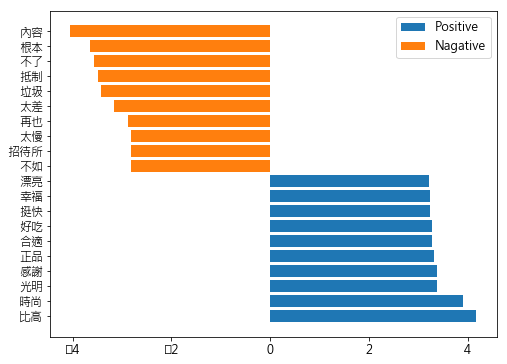

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6)) 
plt.rcParams.update({'font.size': 12})

plt.barh(most_p['word'],most_p['log_ratio'], label="Positive")
plt.barh(most_n['word'],most_n['log_ratio'], label="Nagative")
plt.legend()
plt.show()

## Word2Vec 

<b>sg=1:skip-gram, sg=0:cbow</b>

In [55]:
from gensim.models import Word2Vec
model = Word2Vec(df['token_text'], min_count=1, size=300, window=5, sg=1, workers=2)

In [56]:
print(len(model['好吃']))
print(model.most_similar('好吃'))

300
[('光明', 0.9962029457092285), ('香蕉', 0.9907341003417969), ('純', 0.9897199869155884), ('哎', 0.9890453219413757), ('愛', 0.9882086515426636), ('好喝', 0.98780357837677), ('死', 0.9858293533325195), ('奶', 0.9857703447341919), ('今天', 0.9842618703842163), ('喝多', 0.9841402173042297)]


C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
C:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Load pre-trained embedding model

In [57]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("CBOW_iter15_2017-2018.bin", binary = True)
print(len(model['好吃']))
print(model.most_similar('好吃'))

300
[('美味', 0.7263968586921692), ('好喝', 0.7173788547515869), ('可口', 0.6769968271255493), ('吃起來', 0.6553617715835571), ('對味', 0.6405134201049805), ('夠味', 0.6377977132797241), ('難吃', 0.637171745300293), ('涮嘴', 0.6310038566589355), ('超美味', 0.6008163690567017), ('吃', 0.594489574432373)]


C:\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Visualize 

![Alt text](https://adriancolyer.files.wordpress.com/2016/04/word2vec-king-queen-vectors.png?w=600)

In [58]:
from sklearn.decomposition import PCA

labels = []
tokens = []

for word in model.vocab:
    tokens.append(model[word])
    labels.append(word)

X_reduced = PCA(n_components=2).fit_transform(tokens)
print(X_reduced[0])

[ -6.13047396 -11.08147897]


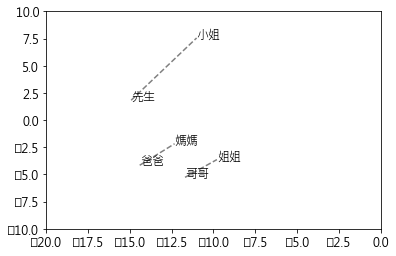

In [59]:
tsne_output = []
words = ['爸爸','媽媽','先生','小姐','哥哥','姐姐']

for w in words:
    index = labels.index(w)
    tsne_output.append(X_reduced[index])

x = []
y = []
for value in tsne_output:
    x.append(value[0])
    y.append(value[1])

for i in range(0, len(x), 2):
    plt.plot(x[i:i+2], y[i:i+2], 'r--',color = "grey")

for i in range(len(x)):
    plt.annotate(words[i],xy=(x[i], y[i]))

plt.ylim(-10, 10)
plt.xlim(-20, 0)
plt.show()

C:\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


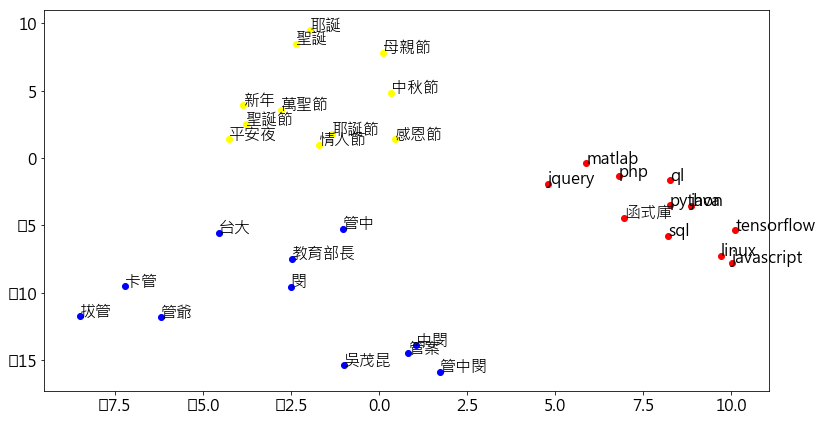

In [61]:
plt.figure(figsize=(13, 7)) 
plt.rcParams.update({'font.size': 16})

def w2vec_plot(word,color):
    text = [x[0] for x in model.most_similar(word)]
    text.append(word)
    tsne_output = []
    for w in text:
        index = labels.index(w)
        tsne_output.append(X_reduced[index])
    for i in range(len(text)):
        plt.scatter(tsne_output[i][0], tsne_output[i][1], color=color)
        plt.annotate(text[i], xy=(tsne_output[i][0], tsne_output[i][1]))

w2vec_plot('python','red')
w2vec_plot('管中閔','blue')
w2vec_plot('聖誕節','yellow')

In [62]:
def avg_w2v_vector(text_list):
    sum_vec = sum([model[word] if word in model else np.zeros(300) for word in text_list])
    result = sum_vec/len(text_list)  
    return result

df['doc_vec'] = df['token_text'].apply(lambda x: avg_w2v_vector(x))
df.head(5)

,tag,text,token_text,doc_vec
0,P,店家很給力，快遞也是相當快，第三次光顧啦,"[店家, 很, 給力, ，, 快遞, 也, 是, 相當快, ，, 第三次, 光顧, 啦]","[-0.13636722415685654, -0.1987149938941002, -0..."
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。,"[這樣, 的, 配置, 用, Vista, 系統, 還是, 有點, 卡, 。, , 指紋,...","[0.4003312134742737, -0.19052192769944667, 0.3..."
2,P,不錯，在同等檔次酒店中應該是值得推薦的！,"[不錯, ，, 在, 同等, 檔次, 酒店, 中應, 該, 是, 值得, 推薦, 的, ！]","[-0.0580126393872958, -3.047916441009595, 0.11..."
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！,"[哎, ！, , 不會, 是, 蒙牛, 乾, 的, 吧, , 嚴懲, 真凶, ！]","[-0.40312377306131214, 0.23361539869354322, 0...."
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字,"[空, 尤其, 是, 三立, 電視, 臺, 女主播, 做, 的, 序, 尤其, 無趣, 像是...","[-0.07393615035449758, -1.5223093111725414, -1..."


## Model

### train/test split 

In [63]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state = 123)
print(len(train))
print(len(test))

5110
1278


C:\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### train 

In [64]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(list(train['doc_vec']), train['tag'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### test 

In [65]:
result = svm_model.predict(list(test['doc_vec']))
print(result)

['N' 'P' 'P' ... 'P' 'N' 'P']


In [66]:
test['predict_svm'] = result
test.head(5)

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,tag,text,token_text,doc_vec,predict_svm
2019,N,好，物流也快，就是安裝費花了200，有點貴。,"[好, ，, 物流, 也, 快, ，, 就是, 安裝費花, 了, 200, ，, 有點, 貴...","[1.184736122643309, -0.5257228527750287, -0.14...",N
2881,P,質感，輕巧。外觀時尚，價格合理,"[質感, ，, 輕巧, 。, 外觀, 時尚, ，, 價格, 合理]","[1.5225927631060283, 1.0276670902967453, -1.18...",P
4037,P,很滿意，全5分,"[很, 滿意, ，, 全, 5, 分]","[2.388674815495809, -1.9856864288449287, 1.092...",P
222,P,金屬外殼，看起比較上檔次。攜帶方便，大一點的包都裝的下。還有正版系統盤，馬上感到放心多了。,"[金屬, 外殼, ，, 看起, 比, 較, 上, 檔次, 。, 攜帶, 方便, ，, 大一點...","[0.9405831903989973, -0.2657707593692788, 0.43...",P
1479,P,"優點大家說得都差不多了.對於支援國產品牌來說,聯想真的是個不錯的選擇.","[優點, 大家, 說, 得, 都, 差不多, 了, ., 對, 於, 支援, 國產, 品牌,...","[-0.49978763548036415, -0.41773459625740844, -...",P


### accuracy 

In [67]:
print(sum(test['tag']==test['predict_svm'])/len(test))

0.8755868544600939


### confusion matrix 

In [68]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(test['tag'],test['predict_svm'],labels=['P', 'N'])
print(conf)
pd.DataFrame(conf, index=['true(P)', 'true(N)'], columns=['pred(P)', 'pred(N)'])

[[534  88]
 [ 71 585]]


,pred(P),pred(N)
true(P),534,88
true(N),71,585


In [69]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(list(train['doc_vec']), train['tag'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
result = logreg.predict(list(test['doc_vec']))
test['predict_log'] = result
test.head(5)

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,tag,text,token_text,doc_vec,predict_svm,predict_log
2019,N,好，物流也快，就是安裝費花了200，有點貴。,"[好, ，, 物流, 也, 快, ，, 就是, 安裝費花, 了, 200, ，, 有點, 貴...","[1.184736122643309, -0.5257228527750287, -0.14...",N,N
2881,P,質感，輕巧。外觀時尚，價格合理,"[質感, ，, 輕巧, 。, 外觀, 時尚, ，, 價格, 合理]","[1.5225927631060283, 1.0276670902967453, -1.18...",P,P
4037,P,很滿意，全5分,"[很, 滿意, ，, 全, 5, 分]","[2.388674815495809, -1.9856864288449287, 1.092...",P,P
222,P,金屬外殼，看起比較上檔次。攜帶方便，大一點的包都裝的下。還有正版系統盤，馬上感到放心多了。,"[金屬, 外殼, ，, 看起, 比, 較, 上, 檔次, 。, 攜帶, 方便, ，, 大一點...","[0.9405831903989973, -0.2657707593692788, 0.43...",P,P
1479,P,"優點大家說得都差不多了.對於支援國產品牌來說,聯想真的是個不錯的選擇.","[優點, 大家, 說, 得, 都, 差不多, 了, ., 對, 於, 支援, 國產, 品牌,...","[-0.49978763548036415, -0.41773459625740844, -...",P,P


In [71]:
print(sum(test['tag']==test['predict_log'])/len(test))

0.8552425665101722


## Demo 

In [79]:
text = '這家餐廳不好吃'
text = list(jieba.cut(text))
print(text)
vec = sum([model[word] if word in model else np.zeros(300) for word in text])
result = logreg.predict(np.reshape(vec,(1,300)))
print(result)

['這家', '餐廳', '不', '好吃']
['N']
